# Analysis of how NFL Team Salary Distributions relate to Win Percentage

We begin by obtaining the required data via Scrapy (I create two Scrapy spiders elsewhere in the project directory in order to do this). Since salary data is expressed in dollars, we account for inflation by standardizing all values in terms of the buying power of a 2013 dollar. Next, we undergo exploratory analysis consisting of a pie chart, box plot, and an attempt at Principal component Analysis. We conclude that salaries for each position group are skewed right, and that there is little redundancy between position groups since we could not meaningfully reduce the number of features using PCA. Next, we regress samples from each position group one at a time with corresponding team win percentage. We find that TE, EDGE, and S are the best predictors of win percentage, although each alone only accounts for less than 4 percent of variance in the response variable. However, we find that the sum of five position groups, QB+WR+TE+EDGE+S, accounts for 7.5 percent of variance, which is more than the 4.5 percent explained by simply summing together all position groups. We ultimately conclude that these are the 5 position groups which general manangers should prioritize in order to construct a winning football team, although there are certainly important variables at play which we have not considered here and which we plan to examine in the near future.

TODO:

-Experiment with mixed linear models to properly account for the structure of the data.

-Apply clustering techniques to the data in order to see if we can find some more interesting patterns; perhaps there are a few competing philosophies or schools of thought that different teams generally apply to their payroll structure.

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

In [3]:
#Import nfl.csv into dataframe, choose the specific features and year ranage that we are interested in.
all_data_df = pd.read_csv('./Data/nfl.csv')
all_data_df = all_data_df[all_data_df.Year <= 2021]

#Inflation adjustment taken from https://www.in2013dollars.com/us/inflation/2013?amount=1
BuyingPowerAdjustment = {2013:1, 2014:.97, 2015:.97, 2016:.96, 2017:.94, 2018:.91, 2019:.9, 2020:.89,
                        2021:.85}


keys = ['QB','RB','WR','TE','OL','IDL','EDGE','LB','S','CB']


df = all_data_df[['QB','RB','WR','TE','OL','IDL','EDGE','LB','S','CB']]

for i in range(len(df)):
    for column in keys:
        df.at[i,column] = BuyingPowerAdjustment[all_data_df.iloc[i]['Year']]*df.at[i,column]


Index(['QB', 'RB', 'WR', 'TE', 'OL', 'IDL', 'EDGE', 'LB', 'S', 'CB'], dtype='object')
[15377571.565972222, 6739440.572916667, 15964011.430555556, 7346052.333333333, 26269848.777777776, 14619045.59375, 16378311.71875, 11229142.826388888, 9920942.166666666, 14513805.427083334]


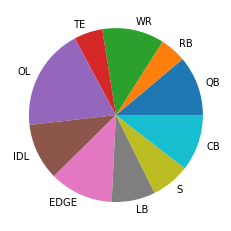

In [4]:
"""
First, let's try to understand how nfl teams typically divide money between position groups. We will begin with a
simple pie chart visualizing how much money goes to each position group on average.

"""

import matplotlib.pyplot as plt
import numpy as np


keys = df.keys()
avgs = []
for key in keys:
    avgs.append(all_data_df[key].mean())
    
plt.pie(avgs, labels = keys)
print(keys)
print(avgs)
# qb_avg = all_data_df['QB'].mean()
# print(qb_avg)


plt.show() 

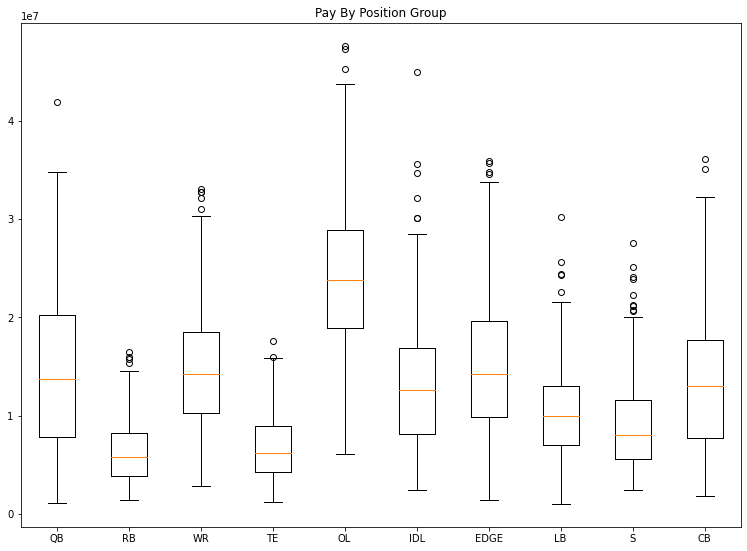

In [5]:
"""
Below we draw a box plot for each position group.
One quick observation from the box plot is that each of the position groups is skewed right. There appears to be
a hard floor for how little a team can get away with spending on a given position group, but there are
outliers in the positive direction for all position groups. It will be worth considering how to address these
outiers in the analysis that follows. For now, we leave them in, since these are high paying teams rather than 
incorrect data.

"""


import matplotlib.pyplot as plt
import numpy as np
 
keys = df.keys()
data = []

for key in keys:
    position_i = df[key].to_numpy()
    data.append(position_i)

fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data, whis=None)
plt.title("Pay By Position Group")
plt.xticks(list(range(1,11)), list(keys))
 
# show plot
plt.show()

In [6]:
#Standardize the data so we can do PCA
df_std = df.iloc[0:].apply(lambda x: (x-x.mean())/x.std())
print(df_std.std()) #just to show that we have normalized the data

QB      1.0
RB      1.0
WR      1.0
TE      1.0
OL      1.0
IDL     1.0
EDGE    1.0
LB      1.0
S       1.0
CB      1.0
dtype: float64


In [7]:
"""
PCA doesn't appear very insightful, since the first principal component only explains 15 percent of the variance.
There is less linear structure in the data than I would have hoped for.

"""

pca = PCA(n_components = 10)
pca.fit(df_std)
print(pca.explained_variance_ratio_)
# print(pca.singular_values_)
print(pca.get_feature_names_out())
print(pca.components_)

[0.14921767 0.13609064 0.11327171 0.11309617 0.10065154 0.09329633
 0.08441301 0.07711632 0.06880679 0.06403982]
['pca0' 'pca1' 'pca2' 'pca3' 'pca4' 'pca5' 'pca6' 'pca7' 'pca8' 'pca9']
[[-0.43800109  0.10852326  0.13836399 -0.3517705  -0.10608031  0.47205585
  -0.25480278 -0.30516895 -0.0647868   0.50710061]
 [-0.1316748   0.34266747 -0.555462   -0.30872503 -0.45082979 -0.23276535
  -0.36485585  0.1222141   0.00539245 -0.23638783]
 [-0.40281775  0.19637863  0.09513225  0.04845493 -0.19134418 -0.34278244
   0.49527689 -0.40830262  0.46908449 -0.04015453]
 [-0.25934691  0.63494152  0.19612861  0.06976521  0.4670435   0.05271058
  -0.0844565   0.46959538  0.18696506 -0.05232713]
 [ 0.28100711 -0.19481974  0.14530004 -0.0098367  -0.08376109 -0.07411834
  -0.44607356  0.0876098   0.77187059  0.21661178]
 [-0.05883335  0.12102395 -0.40528676  0.73150075 -0.03599516  0.43014782
  -0.13578923 -0.23443123  0.13943045 -0.05814434]
 [ 0.37759203  0.24090174 -0.35777625 -0.27440577  0.56944518 -0.

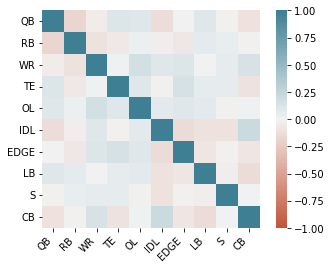

In [8]:
"""
The heatmap below confirms the generally low levels of correlation of salaries between position groups, meaning
there are no variables which we can easily just remove.

"""

# Heatmap code taken from 
#https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
import seaborn as sns

data = df
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [9]:
#Creaing a dictionary to account for the different ways our two data sources name the NFL teams
conversion_dict = {'Eagles':'Philadelphia', 'Seahawks':'Seattle', 'Titans':'Tennessee', 'Broncos':'Denver',
                  'Giants':'NY Giants', 'Texans':'Houston', 'Saints':'New Orleans', 'Vikings':'Minnesota', 
                  'Chargers':'LA Chargers', 'Falcons':'Atlanta', 'Lions':'Detroit', '49ers':'San Francisco', 
                  'Jets':'NY Jets', 'Packers':'Green Bay', 'Patriots':'New England', 'Commanders':'Washington', 
                  'Bears':'Chicago', 'Panthers':'Carolina', 'Cardinals':'Arizona', 'Cowboys':'Dallas', 
                   'Colts':'Indianapolis', 'Chiefs':'Kansas City', 'Rams':'LA Rams', 'Buccaneers':'Tampa Bay', 
                  'Steelers':'Pittsburgh', 'Jaguars':'Jacksonville', 'Bengals':'Cincinnati', 'Ravens':'Baltimore', 
                  'Bills':'Buffalo', 'Dolphins':'Miami', 'Browns':'Cleveland', 'Raiders':'Las Vegas', 
                  }

In [10]:
#Import wins.csv into dataframe, make a list of win percentages with order corresponding to the financial data
df2 = pd.read_csv('./Data/wins.csv')
percentages = []
for i in range(len(df2)):
    team = all_data_df.iloc[i]['Team']
    year = all_data_df.iloc[i]['Year']
    temp = df2[df2.Year == year]
    temp2 = temp[temp.Team == conversion_dict[team]]
    percentages.append(temp2.iloc[0].WinPercent)


print(percentages)

[62.5, 81.3, 43.8, 81.3, 43.8, 12.5, 68.8, 33.3, 56.3, 25.0, 43.8, 75.0, 50.0, 53.3, 75.0, 18.8, 50.0, 75.0, 62.5, 50.0, 68.8, 68.8, 43.8, 25.0, 50.0, 25.0, 68.8, 50.0, 37.5, 50.0, 25.0, 25.0, 37.5, 75.0, 43.8, 56.3, 37.5, 62.5, 31.3, 50.0, 43.8, 56.3, 50.0, 37.5, 68.8, 25.0, 25.0, 12.5, 75.0, 56.3, 68.8, 66.7, 75.0, 75.0, 68.8, 12.5, 18.8, 46.7, 43.8, 75.0, 62.5, 56.3, 68.8, 18.8, 75.0, 68.8, 56.3, 62.5, 43.8, 75.0, 25.0, 43.8, 37.5, 81.3, 50.0, 93.8, 75.0, 31.3, 43.8, 37.5, 62.5, 31.3, 62.5, 25.0, 31.3, 18.8, 68.8, 43.8, 43.8, 37.5, 62.5, 56.3, 50.0, 37.5, 50.0, 18.8, 81.3, 53.3, 68.8, 87.5, 31.3, 68.8, 50.0, 18.8, 37.5, 50.0, 40.0, 56.3, 46.7, 62.5, 75.0, 56.3, 68.8, 18.8, 50.0, 31.3, 43.8, 75.0, 56.3, 56.3, 62.5, 12.5, 43.8, 25.0, 66.7, 43.8, 56.3, 6.3, 81.3, 37.5, 62.5, 43.8, 50.0, 43.8, 81.3, 31.3, 68.8, 68.8, 81.3, 37.5, 56.3, 56.3, 43.8, 56.3, 56.3, 25.0, 56.3, 18.8, 62.5, 25.0, 81.3, 31.3, 62.5, 31.3, 68.8, 56.3, 56.3, 31.3, 0.0, 37.5, 25.0, 25.0, 43.8, 40.0, 43.8, 46.7, 81.3,

In [13]:
#Writing a function to run a t-test on the slope parameter for each of our OLS regressions, with null hypothesis 
#H_0: b_1=0. We do this in order to determine whether a given position group's pay is correlated with team success.
from scipy.stats import t
import math

def t_test(b_1, b_0, X, Y):
    n = len(X)
    S2 = 0
    for i in range(len(X)):
        S2 = S2 + (Y[i]-b_0-b_1*X[i])**2
    
    #S2 at this point has the correct value
    sigprime = math.sqrt(S2/(n-2))
    s_x2 = 0
    for i in range(len(X)):
        s_x2 = s_x2 + (X[i] - np.mean(X))**2
    s_x = math.sqrt(s_x2)
    
    #s_x at this point has the correct value
    u1 = s_x*b_1/sigprime
    p_value = 2*t.cdf(x=-abs(u1), df=(n-2))
    
    return p_value

R^2: 0.012359677050750695
Slope: 2.762821935764219e-07
p_value: 0.05952077427399999


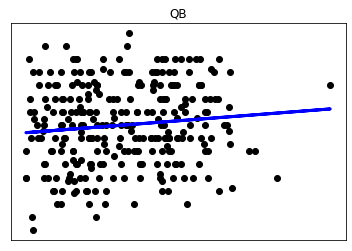

R^2: 0.00017087602572385396
Slope: 7.973458436305298e-08
p_value: 0.8251834459404572


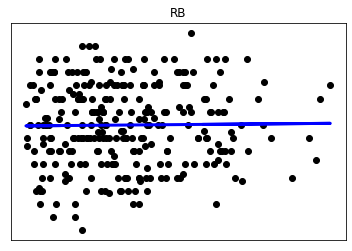

R^2: 0.004884033952826439
Slope: 2.1521863112107103e-07
p_value: 0.23709040919571875


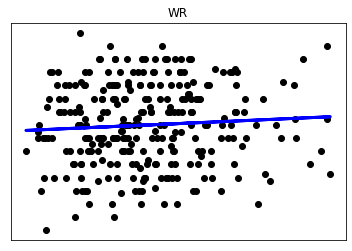

R^2: 0.015202791473583055
Slope: 7.123907735118571e-07
p_value: 0.036496701738985976


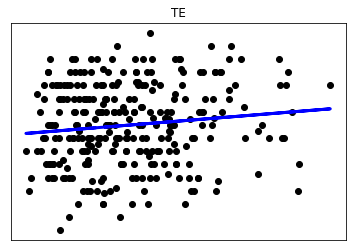

R^2: 0.001349687748392947
Slope: 9.513158266882362e-08
p_value: 0.5346230419274793


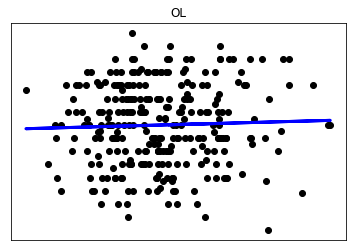

R^2: 0.0013796638156438057
Slope: -1.05019102836832e-07
p_value: 0.5301173120251497


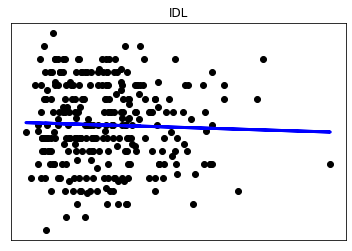

R^2: 0.03781878066413291
Slope: 5.204969154662957e-07
p_value: 0.0009077781500173256


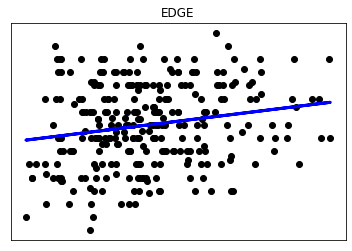

R^2: 0.003920758497410803
Slope: 2.562436607748874e-07
p_value: 0.28957869340817133


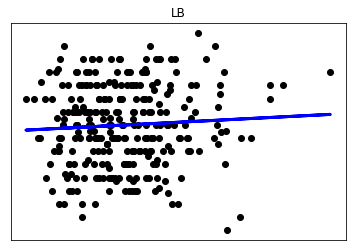

R^2: 0.02654096305386766
Slope: 6.823156734635818e-07
p_value: 0.005584054182730499


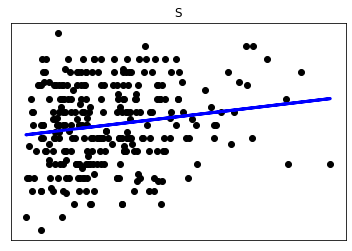

R^2: 2.3208245498951285e-05
Slope: 1.3800687745052738e-08
p_value: 0.9351234526471734


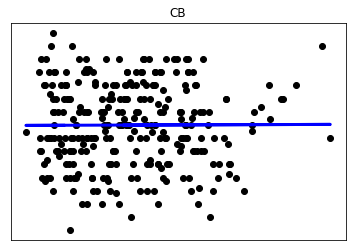

R^2: 0.04589027639803234
Slope: 2.0811643719853794e-07
p_value: 0.00025002879160654823


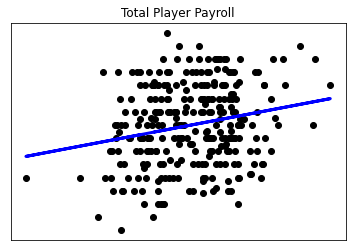

R^2: 0.07500190130812023
Slope: 4.222281787040098e-07
p_value: 2.3825261374717223e-06


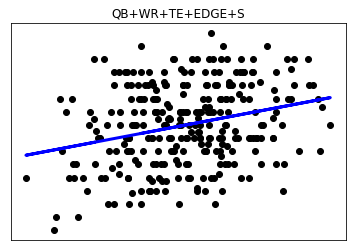

In [14]:
"""
We will try a simple linear regression on one position group at a time. Results are below.

"""
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

for key in df.keys():
    pass
    reg = LinearRegression().fit(np.array(df[key]).reshape(-1, 1), percentages)
    print('R^2:', reg.score(np.array(df[key]).reshape(-1, 1), percentages))
    print('Slope:', reg.coef_[0])
    print('p_value:', t_test(reg.coef_[0], reg.intercept_, np.array(df[key]).reshape(-1, 1), percentages))
    predicted = reg.predict(np.array(df[key]).reshape(-1, 1))
    plt.scatter(np.array(df[key]).reshape(-1, 1), percentages, color="black")
    plt.plot(np.array(df[key]).reshape(-1, 1), predicted, color="blue", linewidth=3)

    plt.title(key)
    plt.xticks(())
    plt.yticks(())

    plt.show()
    
sums_array = []
for i in range(len(df)):
    row_array = np.array(df.iloc[i])
#     sums_array.append((row_array[0] + row_array[2] + row_array[3] + row_array[6] + row_array[8]))
#     sums_array.append((row_array[3] + row_array[6] + row_array[8]))
#     sums_array.append((row_array[1] + row_array[4] + row_array[5] + row_array[7] + row_array[9]))
    sums_array.append(sum(row_array))

#DON'T normalize the sums_array
sums_array = np.array(sums_array)
# mean = sums_array.mean()
# std = sums_array.std()
# for i in range(len(sums_array)):
#     sums_array[i] = (sums_array[i]-mean)/std

reg = LinearRegression(fit_intercept=True).fit(sums_array.reshape(-1, 1), percentages)
print('R^2:', reg.score(sums_array.reshape(-1, 1), percentages))
print('Slope:', reg.coef_[0])
print('p_value:', t_test(reg.coef_[0], reg.intercept_, sums_array.reshape(-1, 1), percentages))
predicted = reg.predict(sums_array.reshape(-1, 1))
plt.scatter(sums_array.reshape(-1, 1), percentages, color="black")
plt.plot(sums_array.reshape(-1, 1), predicted, color="blue", linewidth=3)

plt.title('Total Player Payroll')
plt.xticks(())
plt.yticks(())

plt.show()


sums_array = []
for i in range(len(df)):
    row_array = np.array(df.iloc[i])
#     sums_array.append((row_array[0] + row_array[2] + row_array[3] + row_array[6] + row_array[8]))
    sums_array.append((row_array[0] + row_array[3] + row_array[6] + row_array[8]))
#     sums_array.append((row_array[3] + row_array[6] + row_array[8]))
#     sums_array.append((row_array[1] + row_array[4] + row_array[5] + row_array[7] + row_array[9]))
#     sums_array.append(sum(row_array))

#DON'T
#normalize the sums_array
sums_array = np.array(sums_array)
# mean = sums_array.mean()
# std = sums_array.std()
# for i in range(len(sums_array)):
#     sums_array[i] = (sums_array[i]-mean)/std

reg = LinearRegression(fit_intercept=True).fit(sums_array.reshape(-1, 1), percentages)
print('R^2:', reg.score(sums_array.reshape(-1, 1), percentages))
print('Slope:', reg.coef_[0])
print('p_value:', t_test(reg.coef_[0], reg.intercept_, sums_array.reshape(-1, 1), percentages))
predicted = reg.predict(sums_array.reshape(-1, 1))
plt.scatter(sums_array.reshape(-1, 1), percentages, color="black")
plt.plot(sums_array.reshape(-1, 1), predicted, color="blue", linewidth=3)

plt.title('QB+WR+TE+EDGE+S')
plt.xticks(())
plt.yticks(())

plt.show()

In [15]:
"""
We try a linear regression with four relevant features: QB, TE, EDGE, and S. The resulting R^2 is .08, while the 
adjusted R^2 is .07. 

"""
from sklearn.feature_selection import f_regression


reg = LinearRegression(fit_intercept=True).fit(df[['QB','TE','EDGE','S']], percentages)
reg.score(df[['QB','TE','EDGE','S']], percentages)
# print(percentages)
print(reg.coef_)
print(reg.intercept_)
print(reg.score(df[['QB','TE','EDGE','S']], percentages))
# print(df)
print(f_regression(df[['QB','TE','EDGE','S']], np.array(percentages)))


r2_score = reg.score(df[['QB','TE','EDGE','S']], percentages)
Adj_r2 = 1 - (1-r2_score) * (len(percentages)-1)/(len(percentages)-4-1)
print(Adj_r2)

[2.63250815e-07 4.37880305e-07 4.98034899e-07 6.85229021e-07]
29.41970624641038
0.08396230449195408
(array([ 3.57910421,  4.41512052, 11.24130367,  7.79767319]), array([0.05952077, 0.0364967 , 0.00090778, 0.00558405]))
0.07101477522682276


Based on the above regression results, we see that salaries for only three out of the ten position groups appear to be
correlated with team win percentage at a significance level of .05 on their own: tight ends, edge rushers, and 
safeties. However, even for these position groups, the R^2 values we obtain from OLSregressions
are all less than .04, suggesting that salary information for an individual position group alone cannot reliably
predict a team's success.

This is not to say that we have found no interesting results. For one thing, edge rusher salaries appear to be the
strongest predictor of success among all position groups. 
Several position groups which are typically considered vital, most notably
quarterbacks, wide receivers, and running backs, do not appear to be conclusively correlated with team win percentage.
This leads to the following questions: why does the correlation between player salaries and team win percentage
appear to be so weak? Is salary at some positions not heavily correlated with player ability? Or perhaps some position
groups simply have a smaller impact on the field than others? We will consider these hypotheses later by identifying 
intermediate variables meant to quantify on-field performance for each position group, and then by considering how 
these variables relate to the position group's salary and team success.

However, most interesting is that the sum QB+WR+TE+EDGE+S predicts a team's winning percentage better than total pay
for all positions (OLS R^2=.067 with QB+WR+TE+EDGE+S as the explanatory variable and p=8.9*10^-6, while R^2=.036 with
total pay for all positions as the explanatory variable and p=.001). We explore this further below.  

R^2: 0.0048590573712889995
Slope: 23.522554168310414
p_value: 0.23829614593674991


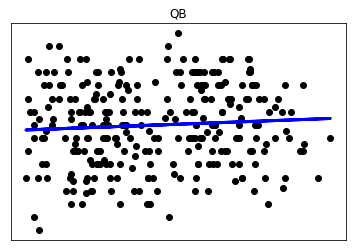

R^2: 0.0032544228487387805
Slope: -39.57215500581363
p_value: 0.33469283738315636


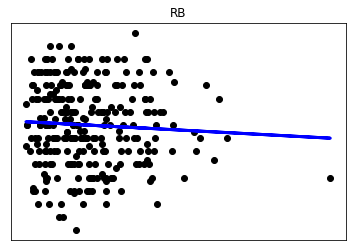

R^2: 7.4687382720650675e-06
Slope: -1.2372341201544188
p_value: 0.9631689957586143


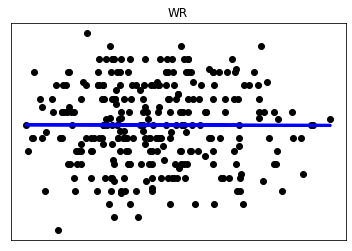

R^2: 0.0043136867549118385
Slope: 50.69389308741446
p_value: 0.2665871056758693


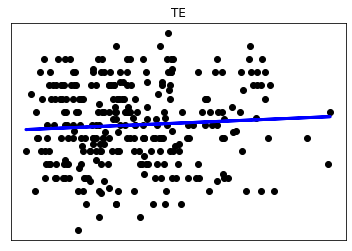

R^2: 0.010439335049298615
Slope: -40.33273548457167
p_value: 0.08346493789035903


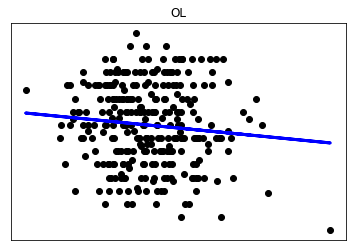

R^2: 0.010464733474571775
Slope: -39.4382318156604
p_value: 0.08308827480418822


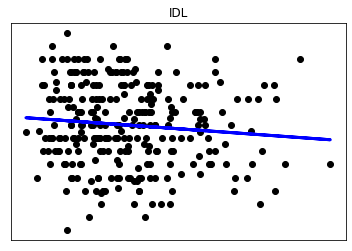

R^2: 0.017821394369956556
Slope: 49.07871896955957
p_value: 0.023462773662135544


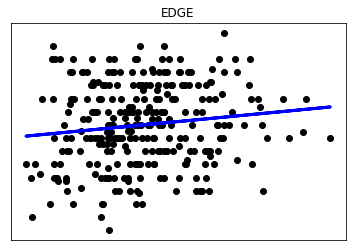

R^2: 0.0009492314463620533
Slope: -16.54454261557036
p_value: 0.6025715954680483


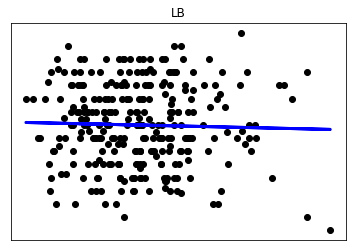

R^2: 0.007026988534782674
Slope: 44.38381088939474
p_value: 0.15592661434128688


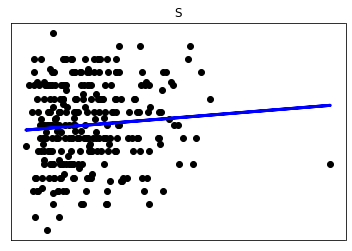

R^2: 0.003191253888071288
Slope: -22.27309812055865
p_value: 0.33943563913937436


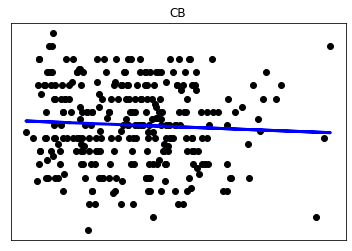

In [17]:
"""
We repeat the above OLS regressions, except now the explanatory variable for each
position group is the proportion of total payroll that goes to the position group instead of absolute dollar amounts. 
This time the only position group for which proportion of payroll appears to be correlated with team winning
percentage at significance level of .05 is EDGE.

"""
all_data_df = pd.read_csv('./Data/nfl.csv')
all_data_df = all_data_df[all_data_df.Year <= 2021]
salary_proportions = all_data_df[['QB','RB','WR','TE','OL','IDL','EDGE','LB','S','CB']].copy()

for i in range(len(salary_proportions)):
    row_array = list(salary_proportions.iloc[i])
    new_row_array = np.array(row_array)/sum(row_array)

    salary_proportions.iloc[i] = new_row_array


import matplotlib.pyplot as plt
for key in salary_proportions.keys():
    pass
    reg = LinearRegression(fit_intercept=True).fit(np.array(salary_proportions[key]).reshape(-1, 1), percentages)
#     print(reg.score(np.array(salary_proportions[key]).reshape(-1, 1), percentages))
    print('R^2:', reg.score(np.array(salary_proportions[key]).reshape(-1, 1), percentages))
    print('Slope:', reg.coef_[0])
    print('p_value:', t_test(reg.coef_[0], reg.intercept_, np.array(salary_proportions[key]).reshape(-1, 1), 
                             percentages))

    predicted = reg.predict(np.array(salary_proportions[key]).reshape(-1, 1))
    plt.scatter(np.array(salary_proportions[key]).reshape(-1, 1), percentages, color="black")
    plt.plot(np.array(salary_proportions[key]).reshape(-1, 1), predicted, color="blue", linewidth=3)

    plt.title(key)
    plt.xticks(())
    plt.yticks(())

    plt.show()
    


R^2: 0.03687999976988465
Slope: -45.696265326015876
p_value: 0.001055045342818476


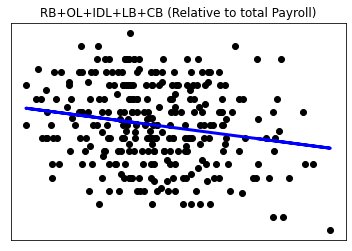

In [18]:
"""
Below we do an
OLS Regression, where x_i is proportion of total pay that goes to RB+OL+IDL+LB+CB. We use these position groups since
they are precisely the ones which we did not identify as particularly important in our earlier regression. Sure
enough, there appears to be a significant negative correlation between proportion of pay going to RB+OL+IDL+LB+CB and 
winning percentage. Thus, it appears that football teams are punished for investing disproportionately in these
position groups over QB+WR+TE+EDGE+S. This finding, along with the positive correlation between total money spend on 
QB+WR+TE+EDGE+S which we demonstrate above, could suggest that NFL teams should prioritize spending money on the
position groups QB, WR, TE, EDGE, and S, and should only pursue expensive players belonging to RB, OL, IDL, LB, or CB 
when their needs in the primary position groups have been met. However, it could also mean the opposite; perhaps the 
teams which splurge on QB, WR, TE, EDGE, and S players are successful because they already had good players
at the other positions first. We will consider these possibilities below.

"""

# print(salary_proportions)
TeEdgeS = []
for i in range(len(salary_proportions)):
    row_array = list(salary_proportions.iloc[i])
#     print(row_array)
    value = row_array[1] + row_array[4] + row_array[5] + row_array[7] + row_array[9]
#     value = row_array[0] + row_array[2] + row_array[3] + row_array[6] + row_array[8]
    TeEdgeS.append(value)
    
reg_TeEdgeS = LinearRegression().fit(np.array(TeEdgeS).reshape(-1, 1), percentages)
#     print(reg.score(np.array(salary_proportions[key]).reshape(-1, 1), percentages))
print('R^2:', reg_TeEdgeS.score(np.array(TeEdgeS).reshape(-1, 1), percentages))
print('Slope:', reg_TeEdgeS.coef_[0])
print('p_value:', t_test(reg_TeEdgeS.coef_[0], reg_TeEdgeS.intercept_, np.array(TeEdgeS).reshape(-1, 1), 
                         percentages))

predicted = reg_TeEdgeS.predict(np.array(TeEdgeS).reshape(-1, 1))
plt.scatter(np.array(TeEdgeS).reshape(-1, 1), percentages, color="black")
plt.plot(np.array(TeEdgeS).reshape(-1, 1), predicted, color="blue", linewidth=3)

plt.title('RB+OL+IDL+LB+CB (Relative to total Payroll)')
plt.xticks(())
plt.yticks(())

plt.show()


R^2: 0.01955462799752883
Slope: -33.31043046903477
p_value: 0.018177787329904008


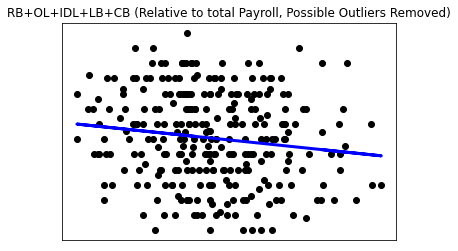

In [19]:
"""
Three points in the bottom right seem to stick out as outliers. We remove them in order to see if our analysis 
would still hold. Although this lowers the R^2 value and significance of our findings, there still appears to be
a correlation.
"""

TeEdgeS = []
for i in range(len(salary_proportions)):
    row_array = list(salary_proportions.iloc[i])
    value = row_array[1] + row_array[4] + row_array[5] + row_array[7] + row_array[9]
#     value = row_array[0] + row_array[2] + row_array[3] + row_array[6] + row_array[8]
    TeEdgeS.append(value)
percentages2 = list(percentages.copy())
# print(np.sort(percentages2))

toRemove = []
for i in range(len(percentages)):
    if percentages[i] < 6.4:
        toRemove.append(i)   


toRemove = sorted(toRemove, reverse=True)
for index in toRemove:
    percentages2.pop(index)
    TeEdgeS.pop(index)
    
reg_TeEdgeS = LinearRegression().fit(np.array(TeEdgeS).reshape(-1, 1), percentages2)
#     print(reg.score(np.array(salary_proportions[key]).reshape(-1, 1), percentages2))
print('R^2:', reg_TeEdgeS.score(np.array(TeEdgeS).reshape(-1, 1), percentages2))
print('Slope:', reg_TeEdgeS.coef_[0])
print('p_value:', t_test(reg_TeEdgeS.coef_[0], reg_TeEdgeS.intercept_, np.array(TeEdgeS).reshape(-1, 1), 
                         percentages2))

predicted = reg_TeEdgeS.predict(np.array(TeEdgeS).reshape(-1, 1))
plt.scatter(np.array(TeEdgeS).reshape(-1, 1), percentages2, color="black")
plt.plot(np.array(TeEdgeS).reshape(-1, 1), predicted, color="blue", linewidth=3)

plt.title('RB+OL+IDL+LB+CB (Relative to total Payroll, Possible Outliers Removed)')
plt.xticks(())
plt.yticks(())

plt.show()


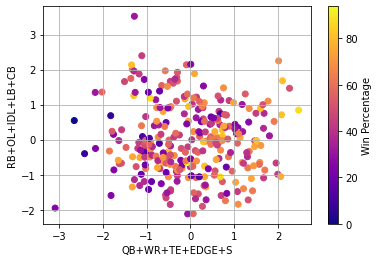

26 32
Frequency analysis: (low,low) = 82 (low, high) = 61 (high, low) = 71 (high, high) = 74
Average win percentage per quadrant: (low,low) = 46.79 (low, high) = 47.46 (high, low) = 55.32 (high, high) = 50.55


In [20]:
"""
We consider the two possibilities alluded to above by creating two variables and then examining
how they relate to each other and to team win percentage: QB+WR+TE+EDGE+S total payment, and RB+OL+IDL+LB+CB total 
payment. We split the data into quadrants based on these variables; quadrant 00 refers to the top left of the graph,
or points for which QB+WR+TE+EDGE+S spending is below average but RB+OL+IDL+LB+CB is above average. Quadrant 10 refers
to the bottom left corner of the graph (low,low), quadrant 01 the top right (high, high), and quadrant 11 is the 
bottom right (high,low).

"""

Xsums_array = []
Ysums_array = []
for i in range(len(df)):
    row_array = np.array(df.iloc[i])
    Xsums_array.append((row_array[0] + row_array[2] + row_array[3] + row_array[6] + row_array[8]))
#     Xsums_array.append((row_array[0]  + row_array[3] + row_array[6] + row_array[8]))
    Ysums_array.append((row_array[1] + row_array[4] + row_array[5] + row_array[7] + row_array[9]))


Xsums_array = np.array(Xsums_array)
Ysums_array = np.array(Ysums_array)

#Standardizing the data
Xsums_array = (Xsums_array-Xsums_array.mean())/(Xsums_array.std())
Ysums_array = (Ysums_array-Ysums_array.mean())/(Ysums_array.std())


plt.scatter(Xsums_array, Ysums_array, c=percentages, cmap="plasma")
cbar = plt.colorbar()
cbar.set_label('Win Percentage')
plt.xlabel('QB+WR+TE+EDGE+S')
plt.ylabel('RB+OL+IDL+LB+CB')

Xsums_array = np.reshape(Xsums_array, (-1, 1))
Ysums_array = np.reshape(Ysums_array, (-1, 1))

reg_TeEdgeS = LinearRegression(fit_intercept=True).fit(Xsums_array, Ysums_array)
#     print(reg.score(np.array(salary_proportions[key]).reshape(-1, 1), percentages2))
# print('R^2:', reg_TeEdgeS.score(Xsums_array, Ysums_array))
# print('Slope:', reg_TeEdgeS.coef_[0])
# print('p_value:', t_test(reg_TeEdgeS.coef_[0], reg_TeEdgeS.intercept_, Xsums_array, 
#                          Ysums_array))

predicted = reg_TeEdgeS.predict(Xsums_array)
# plt.scatter(np.array(TeEdgeS).reshape(-1, 1), percentages2, color="black")
# plt.plot(Xsums_array, predicted, color="blue", linewidth=3)

# plt.title('RB+OL+IDL+LB+CB (Relative to total Payroll, Possible Outliers Removed)')
# plt.xticks(())
# plt.yticks(())




plt.grid()

plt.show()

quadrants = [[0,0],
             [0,0]]
avgs00 = []
avgs01 = []
avgs10 = []
avgs11 = []
avgs20 = []
avgs02 = []

avgs = [[0,0],
        [0,0]]

iOfInterest = []

for i in range(len(Xsums_array)):
    if Xsums_array[i] <= 0 and Ysums_array[i] <= 0:    #NEED TO CHANGE 1'S BACK TO 0'S
        quadrants[1][0] += 1
#         iOfInterest.append(i)
        avgs10.append(percentages[i])
    if Xsums_array[i] > 0 and Ysums_array[i] <= 0:
        quadrants[1][1] += 1
#         iOfInterest.append(i)
        avgs11.append(percentages[i])
    if Xsums_array[i] <= 0 and Ysums_array[i] > 0:
        quadrants[0][0] += 1
#         iOfInterest.append(i)
        avgs00.append(percentages[i])
    if Xsums_array[i] > 0 and Ysums_array[i] > 0:
        quadrants[0][1] += 1 
        iOfInterest.append(i)
        avgs01.append(percentages[i])
    
    if Xsums_array[i] > 1 and Ysums_array[i] <= 0:
#         quadrants[0][1] += 1 
#         iOfInterest.append(i)
        avgs20.append(percentages[i])
        
    if Xsums_array[i] <= 0 and Ysums_array[i] > 1:
#         quadrants[0][1] += 1 
#         iOfInterest.append(i)
        avgs02.append(percentages[i])
    
#     else:
#         print('error')
        
# print(quadrants)

print(len(avgs20),len(avgs02))

avgs[0][0] = np.array(avgs00).mean()
avgs[0][1] = np.array(avgs01).mean()
avgs[1][0] = np.array(avgs10).mean()
avgs[1][1] = np.array(avgs11).mean()

print('Frequency analysis:', '(low,low) =', quadrants[1][0], '(low, high) =', quadrants[0][0], '(high, low) =',
     quadrants[1][1], '(high, high) =', quadrants[0][1])
print('Average win percentage per quadrant:', '(low,low) =', round(avgs[1][0], 2), '(low, high) =', 
      round(avgs[0][0], 2), '(high, low) =', round(avgs[1][1], 2), '(high, high) =', round(avgs[0][1], 2))


(42.287959623736015, 52.62679447462463)
(42.659719737791555, 50.91345099391577)
(46.1442926518987, 54.947599239993174)
(51.31232224352104, 59.32993127760572)
(55.02682363538263, 65.35009944154044)
(44.29879491103701, 56.86370508896299)


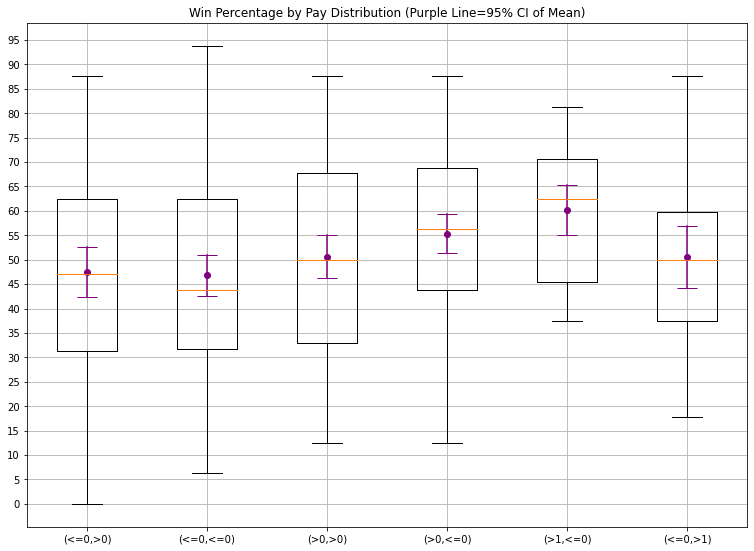

In [21]:
"""
We further examine these four datasets with a box plot overlayed with 95% confidence intervals for each mean. 
The box plot suggests that each dataset is somewhat centered. Additionally, the means are comparable to the medians.

"""

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
 
labels = ['(<=0,>0)', '(<=0,<=0)', 
         '(>0,>0)', '(>0,<=0)', '(>1,<=0)', 
          '(<=0,>1)']
data = []
data.append(avgs00)
data.append(avgs10)
data.append(avgs01)
data.append(avgs11)
data.append(avgs20)
data.append(avgs02)


fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data, whis=None)
plt.title("Win Percentage by Pay Distribution (Purple Line=95% CI of Mean)")
plt.xticks(list(range(1,7)), list(labels))


for i in range(len(data)):
    dataset = data[i]
    tuple1 = st.norm.interval(alpha=0.95, loc=np.mean(np.array(dataset)), scale=st.sem(np.array(dataset)))
    plt.plot([i+1,i+1],[tuple1[0],tuple1[1]],'_-',color='purple',markersize=20)
    plt.plot([i+1],[np.mean(np.array(dataset))],'o',color='purple')
    print(tuple1)

plt.yticks(np.arange(0, 100, step=5))
plt.grid()
plt.show()




Note: Below 'low' denotes below 2013-2021 league average (inflation adjusted) and 'high' denotes above league 
average spending on a compound position group. 
Group 1 referes to the sum of QB+WR+TE+EDGE+S pay and group 2 refers to RB+OL+IDL+LB+CB.   

The most notable finding above is that while the (low,low) and (low,high) distributions looks quite similar in terms
of their sample means, (high,low) seems to correspond to higher win percentage on average compared to (low,low), 
since the 95% confidence intervals of the population means for (low,low) and (high,low) are disjoint. 
Thus, it appears that teams that put a lot of money
into QB,WR,TE,EDGE,S positions and put only a little into RB,OL,IDL,LB,CB do significantly better on average than
teams put only a little into both. For some reason, (high,high) does not
perform significantly better than any other group, and seems to actually perform comparably or worse than (high,low).
Whether this is significant or simply a statistical aberration is left for further study.

Additionally, teams that put more than one standard deviation above the average into position group 1 and any amount
below league average into position group 2 appear to significantly outperform not only (low,high) and (low,low), but
also (high,high). Win percentages for teams which allocate less than league average into group 1 and more than 1
standard deviation above league average for group 2 are not significantly different from any other dataset.
Thus, it appears that very high spending in group 1 is rewarded, while the same cannot be said for
group 2. Finally, there is not enough data to analyze teams which spend more than 1 standard deviation above the
average in both position groups.

Because none of the models above really account for a high level of variance, I next
plan on considering intermediate variables which directly measure a player's impact on the field, and seeing
how these variables relate to money spent on players and team winning percentage. This may help answer the question 
of whether NFL teams typically lose value because player's don't live up to their expectations, or whether the
success of some position groups on the field doesn't translate to wins.

Additionally, linear regression models are typically made with the assumption that observations are independent of one another. However, winning percentages of a single team from year to year are likely heavily dependent, since teams retain a large proportion of their players, personnel, and culture between seasons. Linear mixed models may help with this. Another source of dependence is the fact that teams compete with one another, meaning team winning percentages are related to one another.